### Libraries

In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats

### Data Files

In [6]:
src_srtm = rasterio.open('data/srtm.tif')
src_nlcd = rasterio.open('data/nlcd.tif')
src_grain = rasterio.open('output/grain.tif')
src_elev = rasterio.open('output/elev.tif')
src_dem = rasterio.open('data/dem.tif')
zion = gpd.read_file('data/zion.gpkg')
zion_points = gpd.read_file('data/zion_points.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')
us_states = gpd.read_file('data/us_states.gpkg')
nz = gpd.read_file('data/nz.gpkg')
src_nz_elev = rasterio.open('data/nz_elev.tif')

### Raster Cropping and Masking Using Vector Layers

Masking does not change the extent of the raster. It can mean many nan or nonsense values.

Cropping does change the extent of the raster.

In [18]:
# It's usually simpler to change the vector crs than the ratser crs
zion = zion.to_crs(src_srtm.crs)

# masking
out_image_mask, out_transform_mask = rasterio.mask.mask(
    src_srtm, 
    # must pass geometries, not gdf
    zion.geometry, 
    crop=False, 
    nodata=9999)

# update nodata for writing file
dst_kwargs = src_srtm.meta
dst_kwargs.update(nodata=9999)
new_dataset = rasterio.open('output/srtm_masked.tif', 'w', **dst_kwargs)
new_dataset.write(out_image_mask)
new_dataset.close()

In [17]:
# create box to crop raster image
bb = zion.union_all().envelope

# crop raster
out_image_crop, out_transform_crop = rasterio.mask.mask(
    src_srtm, 
    [bb], 
    crop=True, 
    all_touched=True, 
    nodata=9999)

In [16]:
# crop and mask combined
out_image_mask_crop, out_transform_mask_crop = rasterio.mask.mask(
    src_srtm, 
    zion.geometry, 
    crop=True, 
    nodata=9999)

# must update the transform
dst_kwargs = src_srtm.meta
dst_kwargs.update({
    'nodata': 9999,
    'transform': out_transform_mask_crop,
    'width': out_image_mask_crop.shape[2],
    'height': out_image_mask_crop.shape[1]})

# write transformed raster
new_dataset = rasterio.open(
    'output/srtm_masked_cropped.tif', 
    'w', 
    **dst_kwargs)

new_dataset.write(out_image_mask_crop)
new_dataset.close()

Text(0.5, 1.0, 'Masked + Cropped')

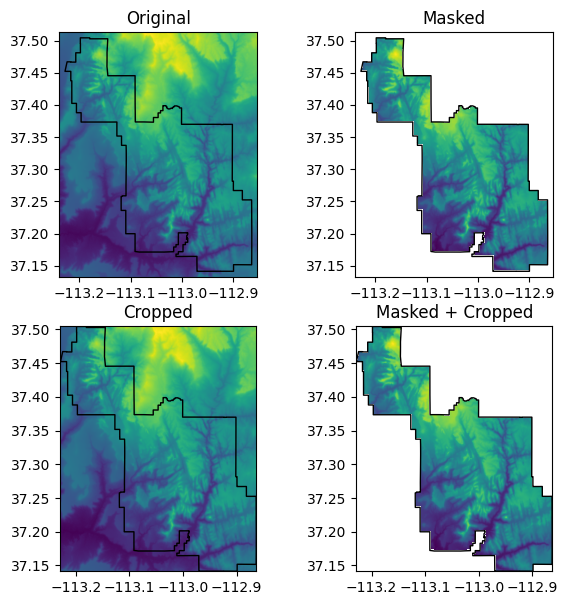

In [20]:
src_srtm_mask_crop = rasterio.open('output/srtm_masked_cropped.tif')
src_srtm_mask = rasterio.open('output/srtm_masked.tif')

fig, ax = plt.subplots(2, 2, figsize=(7,7))
rasterio.plot.show(src_srtm, ax=ax[0,0])
zion.plot(ax=ax[0,0], color='none', edgecolor='black')
ax[0,0].set_title('Original')
rasterio.plot.show(src_srtm_mask, ax=ax[0,1])
zion.plot(ax=ax[0,1], color='none', edgecolor='black');
ax[0,1].set_title('Masked')
rasterio.plot.show(out_image_crop, transform=out_transform_crop, ax=ax[1,0])
zion.plot(ax=ax[1,0], color='none', edgecolor='black')
ax[1,0].set_title('Cropped')
rasterio.plot.show(src_srtm_mask_crop, ax=ax[1,1])
zion.plot(ax=ax[1,1], color='none', edgecolor='black')
ax[1,1].set_title('Masked + Cropped')

### Raster Extraction 

* Point Extraction - Query a raster for values at specific points.
* Line Extraction - Extract raster values across a line.
* Polygon Extraction - Extract values (or statistics) from a raster using polygons.

In [22]:
# Point Extraction
result1 = rasterstats.point_query(
    zion_points, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform,
    interpolate='nearest')

# can also just pass the raster file, where the parameters are mostly inferred
result2 = rasterstats.point_query(
    zion_points, 
    'data/srtm.tif',
    interpolate='nearest'
)

result1 == result2

True

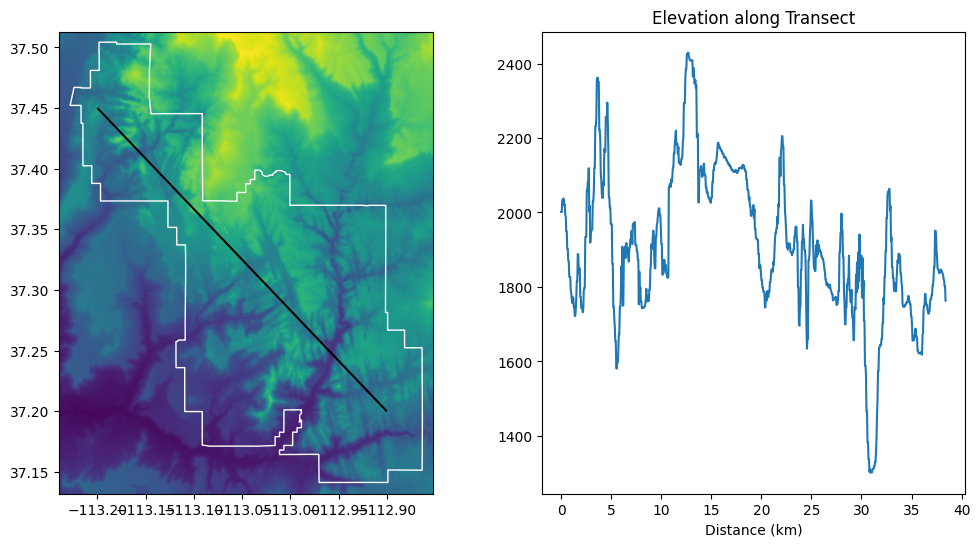

In [95]:
# Line Extraction
coords = [[-113.2, 37.45], [-112.9, 37.2]]
zion_transect = shapely.LineString(coords)

zion_transect_utm = gpd.GeoSeries(zion_transect, crs=4326).to_crs(32612)
zion_transect_utm = zion_transect_utm.iloc[0]

# Create Linestring of points along transect
distances = np.arange(0, zion_transect_utm.length, 50)

# Points interpolated along transect at regular distance
zion_transect_pnt = gpd.GeoSeries([zion_transect_utm.interpolate(d) for d in distances], crs=32612).to_crs(src_srtm.crs)

# Extract elevation values from raster with a point query
result = rasterstats.point_query(
    zion_transect_pnt, 
    src_srtm.read(1), 
    nodata = src_srtm.nodata, 
    affine = src_srtm.transform,
    interpolate='nearest')

zion_transect_pnt = gpd.GeoDataFrame(geometry=zion_transect_pnt)
zion_transect_pnt['dist'] = distances*0.001
zion_transect_pnt['elev'] = result

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
rasterio.plot.show(src_srtm, ax=ax[0])
gpd.GeoSeries(zion_transect).plot(ax=ax[0], color='black')
zion.plot(ax=ax[0], color='none', edgecolor='white');
ax[1].plot(zion_transect_pnt['dist'], zion_transect_pnt['elev'])
ax[1].set_title('Elevation along Transect')
ax[1].set_xlabel('Distance (km)')
plt.show()

In [37]:
# Polygon Extraction
result = rasterstats.zonal_stats(
    zion, 
    # can simply pass the path to the raster file
    'data/srtm.tif',
    stats = ['mean', 'min', 'max']
)
result

[{'min': 1122.0, 'max': 2661.0, 'mean': 1818.211830154405}]

In [38]:
out_image, out_transform = rasterio.mask.mask(
    src_nlcd, 
    zion.geometry.to_crs(src_nlcd.crs), 
    crop=False, 
    nodata=src_nlcd.nodata
)
counts = np.unique(out_image, return_counts=True)
counts

(array([  2,   3,   4,   5,   6,   7,   8, 255], dtype=uint8),
 array([  4205,  98285, 298299, 203701,    235,     62,    679, 852741]))

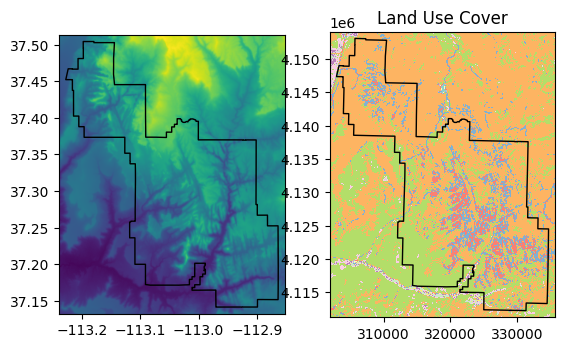

In [42]:
fig, ax = plt.subplots(1, 2)
rasterio.plot.show(src_srtm, ax=ax[0])
zion.plot(ax=ax[0], color='none', edgecolor='black')
ax[1].set_title('Original')
rasterio.plot.show(src_nlcd, ax=ax[1], cmap='Set3')
zion.to_crs(src_nlcd.crs).plot(ax=ax[1], color='none', edgecolor='black')
ax[1].set_title('Land Use Cover')
plt.show()

### Rasterization

Need to specify the template grid and the output format.

In [46]:
# template raster
cycle_hire_osm_projected = cycle_hire_osm.to_crs(27700)

# bounding box corners
bounds = cycle_hire_osm_projected.total_bounds
res = 1000
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=res, 
    ysize=res
)

rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)


In [48]:
# Binary raster
g = [(g, 1) for g in cycle_hire_osm_projected.geometry]

ch_raster1 = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape, 
    transform=transform)

ch_raster1

array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [49]:
# sum of raster values, rather than just binary

g = [(g, 1) for g in cycle_hire_osm_projected.geometry]

ch_raster2 = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
    # this argument creates the values
    merge_alg=rasterio.enums.MergeAlg.add)

ch_raster2

array([[ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  3,  3],
       [ 0,  0,  0,  1,  3,  3,  5,  5,  8,  9,  1,  3,  2,  6,  7,  0],
       [ 0,  0,  0,  8,  5,  4, 11, 10, 12,  9, 11,  4,  8,  5,  4,  0],
       [ 0,  1,  4, 10, 10, 11, 18, 16, 13, 12,  8,  6,  5,  2,  3,  0],
       [ 3,  3,  9,  3,  5, 14, 10, 15,  9,  9,  5,  8,  0,  0, 12,  2],
       [ 4,  5,  9, 11,  6,  7,  7,  3, 10,  9,  4,  0,  0,  0,  0,  0],
       [ 4,  0,  7,  8,  8,  4, 11, 10,  7,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  3,  0,  0,  1,  4,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [51]:
# summing an attribute
g = [(g, v) for g, v in cycle_hire_osm_projected[['geometry', 'capacity']].dropna(subset='capacity').to_numpy().tolist()]

ch_raster3 = rasterio.features.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
    merge_alg=rasterio.enums.MergeAlg.add)

ch_raster3

array([[  0.,   0.,   0.,   0.,   0.,  11.,  34.,   0.,   0.,   0.,   0.,
          0.,   0.,  11.,  35.,  24.],
       [  0.,   0.,   0.,   7.,  30.,  46.,  60.,  73.,  72.,  75.,   6.,
         50.,  25.,  47.,  36.,   0.],
       [  0.,   0.,   0.,  89.,  36.,  31., 167.,  97., 115.,  80., 138.,
         61.,  65., 109.,  43.,   0.],
       [  0.,  11.,  42., 104., 108., 138., 259., 206., 203., 135., 107.,
         37.,   0.,  25.,  60.,   0.],
       [ 88.,  41.,  83.,  28.,  64., 115.,  99., 249., 107., 117.,  60.,
         33.,   0.,   0.,   0.,   0.],
       [  0.,  89., 107.,  95.,  73., 119.,  69.,  23., 140., 141.,  46.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  55.,  97., 101.,  59., 119., 109.,  75.,  12.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,  10.,  23.,   0.,   0.,   5.,  41.,   0.,   8.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,  19.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   

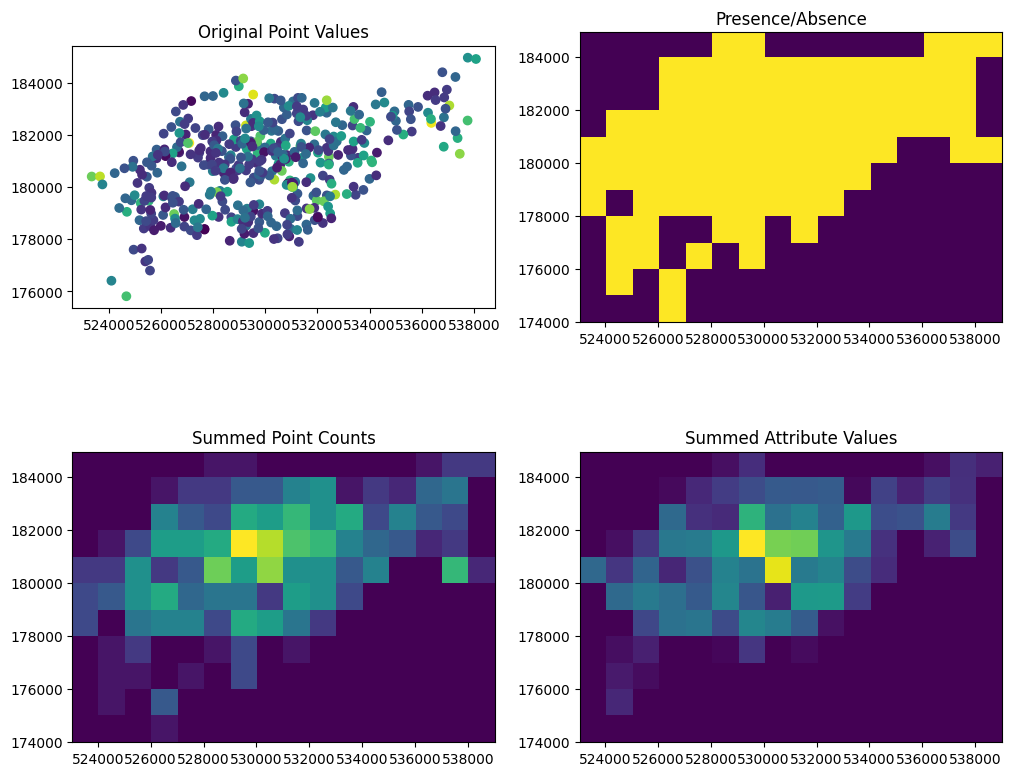

In [53]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))

ax[0,0].set_title('Original Point Values')
cycle_hire_osm_projected.plot(column='capacity', ax=ax[0,0])
ax[0,1].set_title('Presence/Absence')
rasterio.plot.show(ch_raster1, transform=transform, ax=ax[0,1])
ax[1,0].set_title('Summed Point Counts')
rasterio.plot.show(ch_raster2, transform=transform, ax=ax[1,0]);
# Summed attribute values
ax[1,1].set_title('Summed Attribute Values')
rasterio.plot.show(ch_raster3, transform=transform, ax=ax[1,1]);

In [54]:
# Rasterize a Polygon of the California boundaries
california = us_states[us_states['NAME'] == 'California']
california_borders = california.boundary

bounds = california_borders.total_bounds
res = 0.5
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=res, 
    ysize=res
)
rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)
shape

(19, 21)

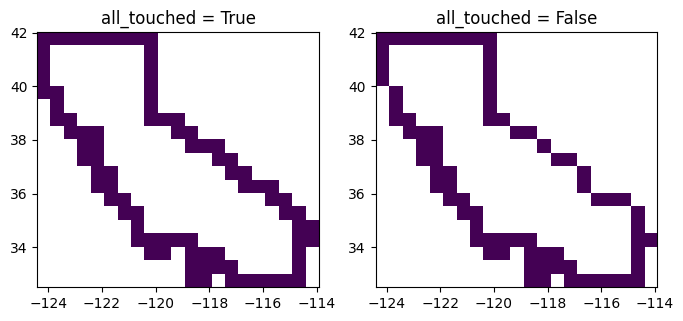

In [68]:
california_raster1 = rasterio.features.rasterize(
    [(g, 1) for g in california_borders],
    out_shape=shape,
    transform=transform,
    all_touched=True,
    fill=np.nan,
    dtype=np.float64)

california_raster2 = rasterio.features.rasterize(
    [(g, 1) for g in california_borders],
    out_shape=shape,
    transform=transform,
    all_touched = False,
    fill=np.nan,
    dtype=np.float64)

fig, ax = plt.subplots(1, 2, figsize = (8,4))
rasterio.plot.show(california_raster1, transform=transform, ax = ax[0])
rasterio.plot.show(california_raster2, transform=transform, ax = ax[1])
ax[0].set_title('all_touched = True')
ax[1].set_title('all_touched = False')
plt.show()

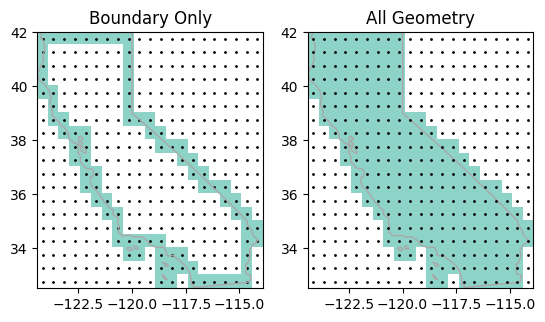

In [70]:
# Version that is a fill rather than line raster
california_raster2 = rasterio.features.rasterize(
    [(g, 1) for g in california.geometry],
    out_shape=shape,
    transform=transform,
    all_touched = True,
    fill=np.nan,
    dtype=np.float64)

# Define Reference Grid
height = california_raster1.shape[0]
width = california_raster1.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
x, y = rasterio.transform.xy(transform, rows, cols)
x = np.array(x).flatten()
y = np.array(y).flatten()
z = california_raster1.flatten()
geom = gpd.points_from_xy(x, y, crs=california.crs)
pnt = gpd.GeoDataFrame(data={'value':z}, geometry=geom)

# Line rasterization
fig, ax = plt.subplots(1, 2)
rasterio.plot.show(california_raster1, transform=transform, ax=ax[0], cmap='Set3')
gpd.GeoSeries(california_borders).plot(ax=ax[0], edgecolor='darkgrey', linewidth=1)
pnt.plot(ax=ax[0], color='black', markersize=1)
ax[0].set_title('Boundary Only')
rasterio.plot.show(california_raster2, transform=transform, ax=ax[1], cmap='Set3')
california.plot(ax=ax[1], color='none', edgecolor='darkgrey', linewidth=1)
pnt.plot(ax=ax[1], color='black', markersize=1)
ax[1].set_title('All Geometry')
plt.show()

### Spatial Vectorization

* Raster to polygons - converts raster cells into rectangular polygons.
* Raster to Points - Converts raster cells to points using their centroids.
* Raster to Contours - Converts rasters into countour lines.

In [79]:
# shapes extracts regions of common pixel values
shapes = rasterio.features.shapes(rasterio.band(src_grain, 1))
pol = list(shapes)
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=src_grain.crs)

values = [i[1] for i in pol]
values = pd.Series(values)
result = gpd.GeoDataFrame({'value': values, 'geometry': geom})
result.head()

,value,geometry
0,1.0,"POLYGON ((-1.5 1.5, -1.5 1, -1 1, -1 1.5, -1.5..."
1,0.0,"POLYGON ((-1 1.5, -1 1, -0.5 1, -0.5 1.5, -1 1..."
2,1.0,"POLYGON ((-0.5 1.5, -0.5 1, 0 1, 0 1.5, -0.5 1..."
3,2.0,"POLYGON ((0 1.5, 0 1, 0.5 1, 0.5 0.5, 1 0.5, 1..."
4,1.0,"POLYGON ((1 1, 1 0.5, 1.5 0.5, 1.5 1, 1 1))"


<Axes: >

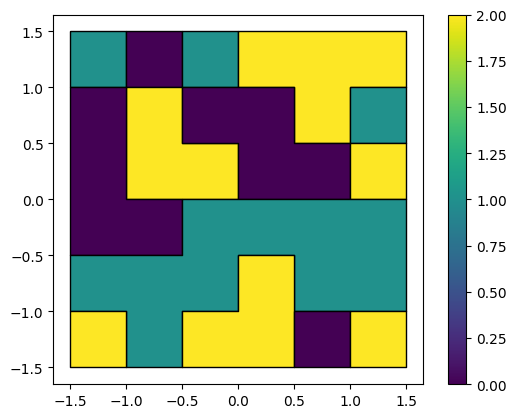

In [80]:
result.plot(column='value', edgecolor='black', legend=True)

In [81]:
src = rasterio.open('output/elev.tif')
rasterio.transform.xy(src.transform, 0, 0)

(np.float64(-1.25), np.float64(1.25))

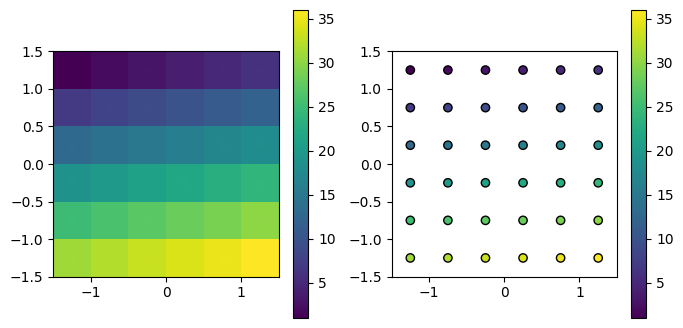

In [85]:
# create grid of pixel centroids
height = src.shape[0]
width = src.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
x, y = rasterio.transform.xy(src.transform, rows, cols)

x = np.array(x).flatten()
y = np.array(y).flatten()
z = src.read(1).flatten()
geom = gpd.points_from_xy(x, y, crs=src.crs)
pnt = gpd.GeoDataFrame(data={'value':z}, geometry=geom)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
pnt.plot(column='value', legend=True, ax=ax[0])
rasterio.plot.show(src_elev, ax=ax[0]);
pnt.plot(column='value', legend=True, edgecolor='black', ax=ax[1])
rasterio.plot.show(src_elev, alpha=0, ax=ax[1]);

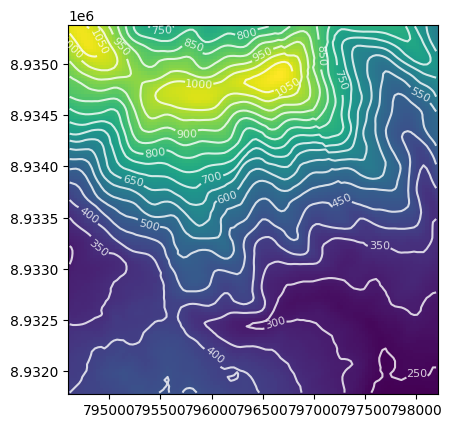

In [88]:
# Contours
fig, ax = plt.subplots()
rasterio.plot.show(src_dem, ax=ax)
rasterio.plot.show(
    src_dem, 
    ax=ax, 
    contour=True, 
    levels=np.arange(0,1200,50), 
    colors='white'
);

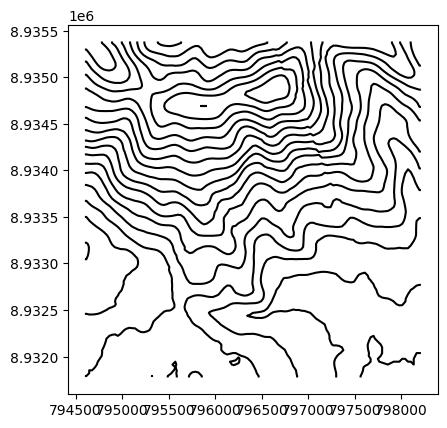

In [91]:
# Use GDAL to create and export the contours.
import os
#os.system('gdal_contour -a elev data/dem.tif output/dem_contour.gpkg -i 50.0')

contours1 = gpd.read_file('output/dem_contour.gpkg')
fig, ax = plt.subplots()
#rasterio.plot.show(src_dem, ax=ax)
contours1.plot(ax=ax, edgecolor='black');

### Distance to Nearest Geometry

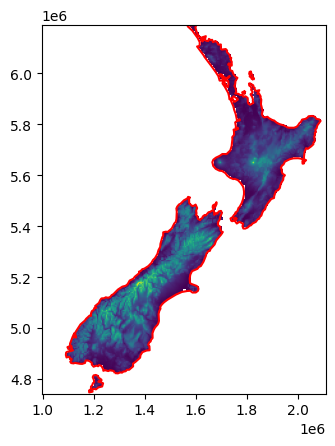

In [93]:
coastline = nz.dissolve().to_crs(src_nz_elev.crs).boundary.iloc[0]

factor = 0.2
# Reading aggregated array
r = src_nz_elev.read(1,
    out_shape=(
        int(src_nz_elev.height * factor),
        int(src_nz_elev.width * factor)),
    resampling=rasterio.enums.Resampling.average)

# Updating the transform
new_transform = src_nz_elev.transform * src_nz_elev.transform.scale(
    (src_nz_elev.width / r.shape[1]),
    (src_nz_elev.height / r.shape[0]))

# Dummy raster of elevations
fig, ax = plt.subplots()
rasterio.plot.show(r, transform=new_transform, ax=ax)
gpd.GeoSeries(coastline).plot(ax=ax, edgecolor='red');

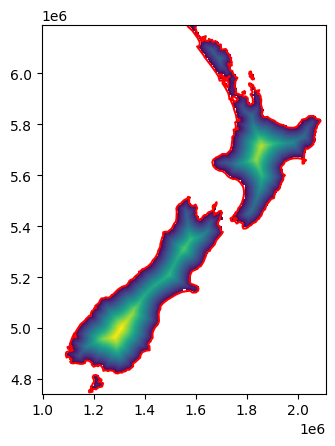

In [94]:
# Convert to raster pixel values
height = r.shape[0]
width = r.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
x, y = rasterio.transform.xy(new_transform, rows, cols)
x = np.array(x).flatten()
y = np.array(y).flatten()
z = r.flatten()
x = x[~np.isnan(z)]
y = y[~np.isnan(z)]
geom = gpd.points_from_xy(x, y, crs=california.crs)
geom = list(geom)

# calculate distances to coastline
distances = [(i, i.distance(coastline)) for i in geom]

image = rasterio.features.rasterize(
    distances,
    out_shape=r.shape,
    dtype=np.float64,
    transform=new_transform,
    fill=np.nan)

fig, ax = plt.subplots()
rasterio.plot.show(image, transform=new_transform, ax=ax)
gpd.GeoSeries(coastline).plot(ax=ax, edgecolor='red');